In [109]:
import zipfile
import os

zip_file_path = "/content/stage1_train.zip"
extract_path = "/content/stage1_train_extracted"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Successfully unzipped '{zip_file_path}' to '{extract_path}'")
print(f"Content of '{extract_path}' after extraction: {os.listdir(extract_path)[:5]}...")

Successfully unzipped '/content/stage1_train.zip' to '/content/stage1_train_extracted'
Content of '/content/stage1_train_extracted' after extraction: ['93cfd412c7de5210bbd262ec3a602cfea65072e9272e9fce9b5339a5b9436eb7', 'ce37f6dd0615d45e66e41a8f2ed6fbc0bbe3103a290394ad474207507710eacc', '5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053', 'b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371fa15f', 'f113626a04125d97b27f21b45a0ce9a686d73dee7b5dbc0725d49194ba0203bd']...


In [110]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy import ndimage as ndi
from random import randint

In [111]:

base_path = "/content/stage1_train_extracted"

image_ids = os.listdir(base_path)
image_id = image_ids[randint(0, len(image_ids) - 1)]

img_path = os.path.join(base_path, image_id, "images", image_id + ".png")

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [112]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


blur = cv2.GaussianBlur(gray, (5,5), 0)


_, thresh = cv2.threshold(blur, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)


kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


In [113]:

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

In [114]:
labels_no_marker = measure.label(opening)

In [115]:
_, sure_fg = cv2.threshold(dist_transform,
                           0.4 * dist_transform.max(),
                           255, 0)

sure_fg = np.uint8(sure_fg)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [116]:
unknown = cv2.subtract(sure_bg, sure_fg)

In [117]:
_, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0

In [118]:
_, thresh = cv2.threshold(blur, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)


In [119]:
markers_ws = cv2.watershed(image, markers)

In [120]:
watershed_result = image.copy()
watershed_result[markers_ws == -1] = [255, 0, 0]

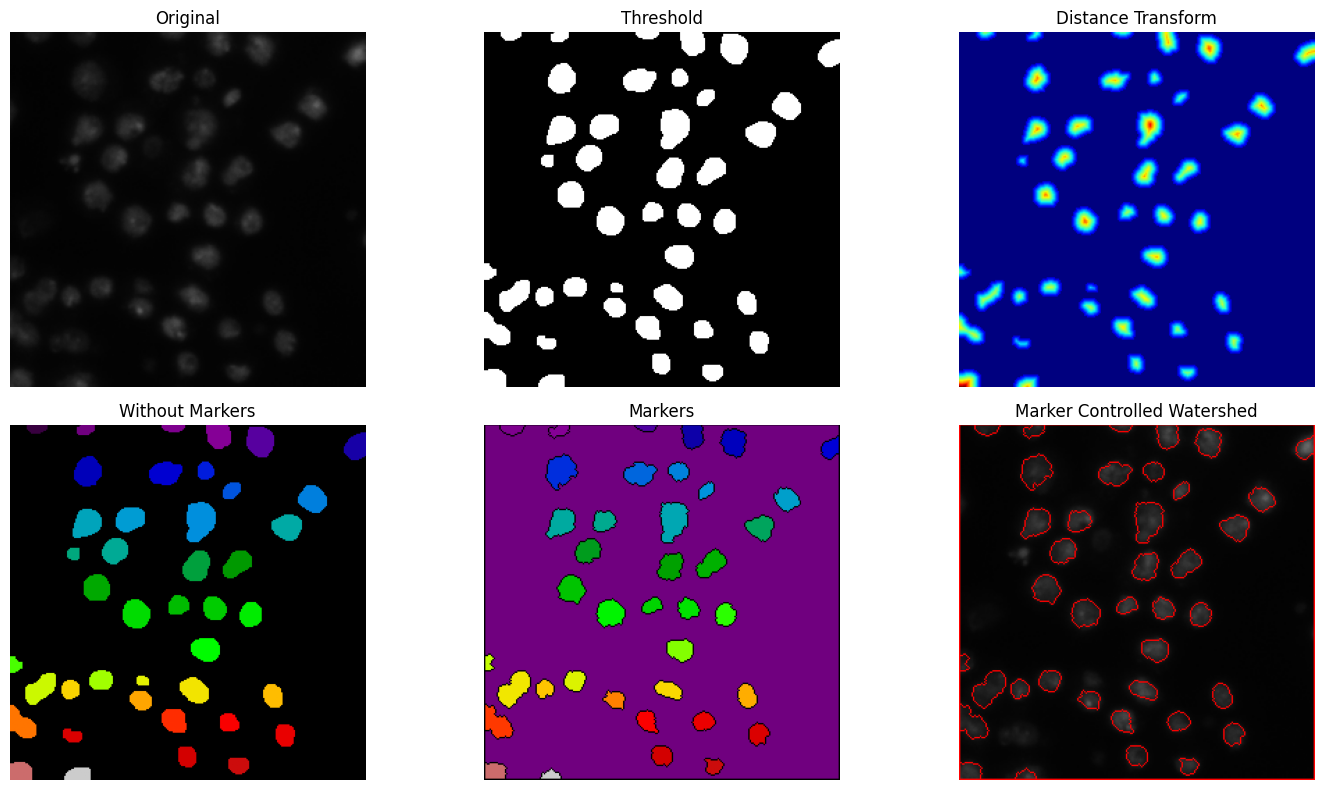

In [121]:
plt.figure(figsize=(15,8))

plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(image)
plt.axis("off")

plt.subplot(2,3,2)
plt.title("Threshold")
plt.imshow(opening, cmap='gray')
plt.axis("off")

plt.subplot(2,3,3)
plt.title("Distance Transform")
plt.imshow(dist_transform, cmap='jet')
plt.axis("off")

plt.subplot(2,3,4)
plt.title("Without Markers")
plt.imshow(labels_no_marker, cmap='nipy_spectral')
plt.axis("off")

plt.subplot(2,3,5)
plt.title("Markers")
plt.imshow(markers, cmap='nipy_spectral')
plt.axis("off")

plt.subplot(2,3,6)
plt.title("Marker Controlled Watershed")
plt.imshow(watershed_result)
plt.axis("off")

plt.tight_layout()
plt.show()

In [122]:

num_objects_no_marker = len(np.unique(labels_no_marker))
num_objects_marker = len(np.unique(markers_ws))

print("Objects WITHOUT marker:", num_objects_no_marker)
print("Objects WITH marker:", num_objects_marker)

Objects WITHOUT marker: 43
Objects WITH marker: 41


In [123]:
%matplotlib inline